In [2]:

import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sb 

import statsmodels.formula.api as sm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

from statsmodels.stats.outliers_influence import OLSInfluence as influence
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from utils.common_transformers import DateHandler, IsNull, Dropper, DTypeTransformer, ColumnSelector

%matplotlib inline

In [3]:
df = pd.read_csv("../data/Train.csv")

In [4]:
df = DateHandler(["date"],date_format="%Y-%m-%d",exclude=["day_name"],).fit_transform(df)
df = IsNull(include=["client_agent"]).fit_transform(df)

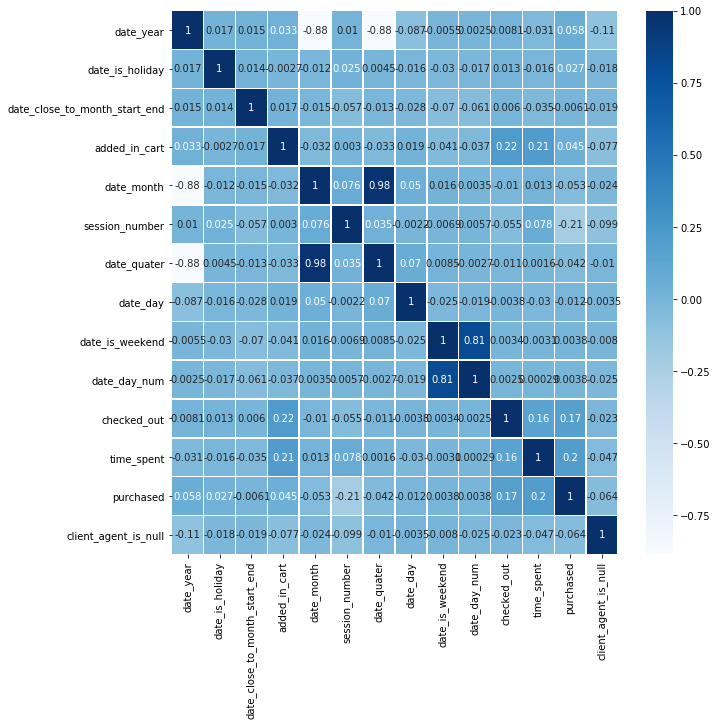

In [5]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sb.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax,cmap="Blues")

In [6]:
num_cols = list(df.select_dtypes(include=[int,float,bool]).columns)
num_cols.remove("time_spent")

In [7]:
formula_str = "time_spent"+' ~ '+'+'.join(num_cols)
formula_str

'time_spent ~ date_year+date_is_holiday+date_close_to_month_start_end+added_in_cart+date_month+session_number+date_quater+date_day+date_is_weekend+date_day_num+checked_out+purchased+client_agent_is_null'

In [8]:
model=sm.ols(formula=formula_str, data=df)
fitted = model.fit()

In [9]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:             time_spent   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     53.53
Date:                Thu, 07 Jan 2021   Prob (F-statistic):          1.17e-131
Time:                        13:38:09   Log-Likelihood:                -47801.
No. Observations:                5429   AIC:                         9.563e+04
Df Residuals:                    5415   BIC:                         9.572e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [10]:
def yes_no(b):
    if b:
        return 'Yes'
    else:
        return 'No'

df_result=pd.DataFrame()
df_result['pvalues']=fitted.pvalues[1:]
df_result['Features']=num_cols
df_result.set_index('Features',inplace=True)
df_result['Statistically significant?']= df_result['pvalues'].apply(yes_no)
df_result

,pvalues,Statistically significant?
Features,,
date_year,9.317567e-02,Yes
date_is_holiday,1.941316e-02,Yes
date_close_to_month_start_end,8.982788e-01,Yes
added_in_cart,5.082840e-02,Yes
date_month,2.547915e-10,Yes
session_number,2.471527e-42,Yes
date_quater,4.251375e-01,Yes
date_day,4.223042e-21,Yes
date_is_weekend,1.108588e-03,Yes


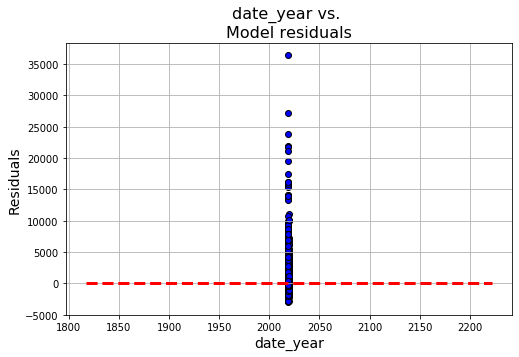

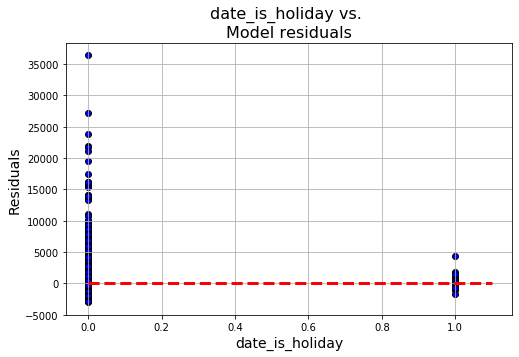

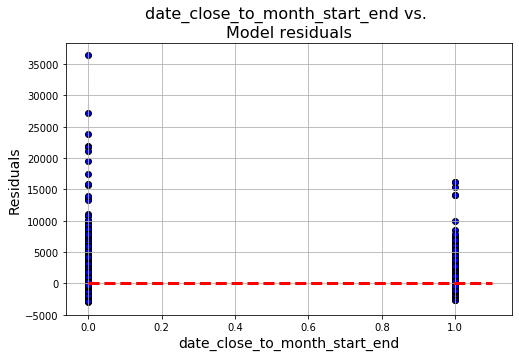

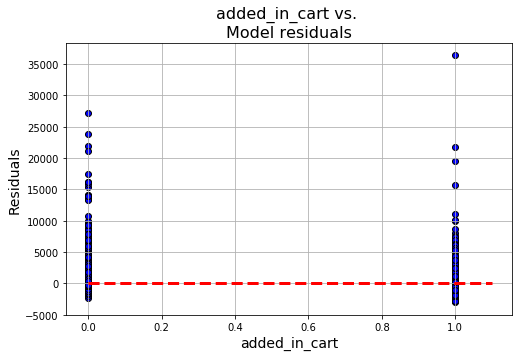

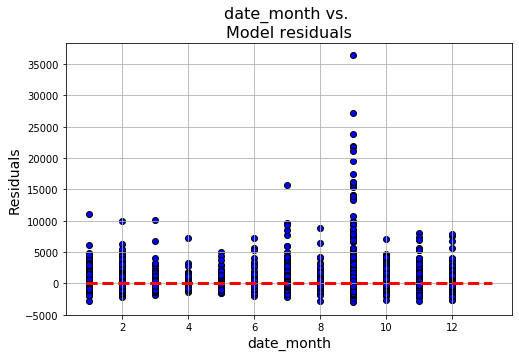

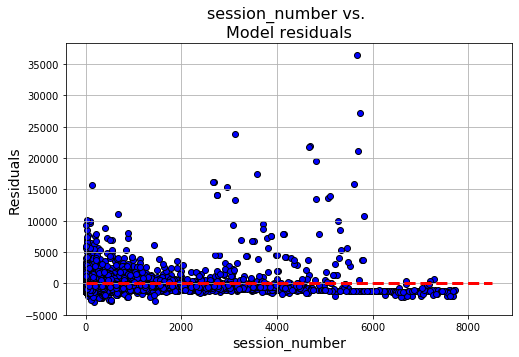

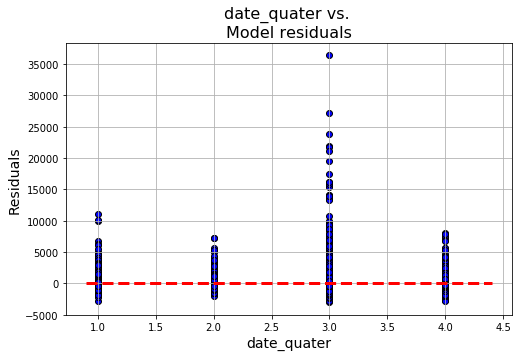

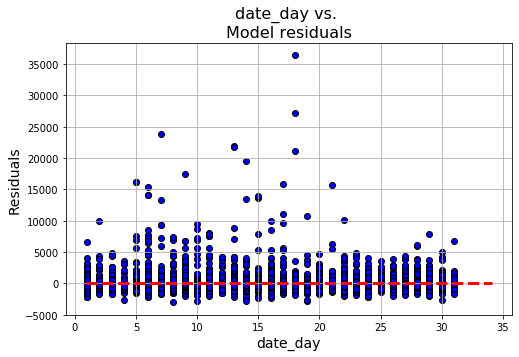

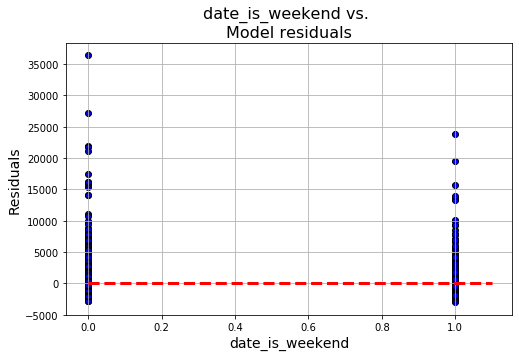

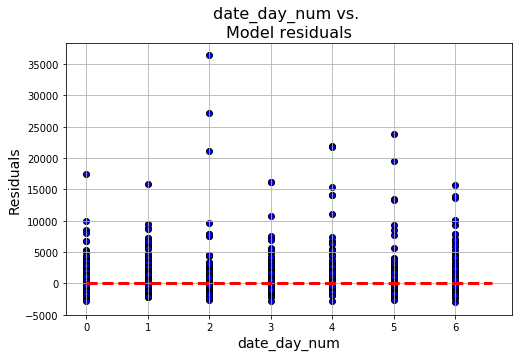

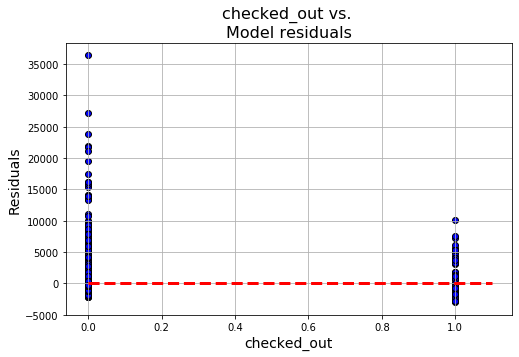

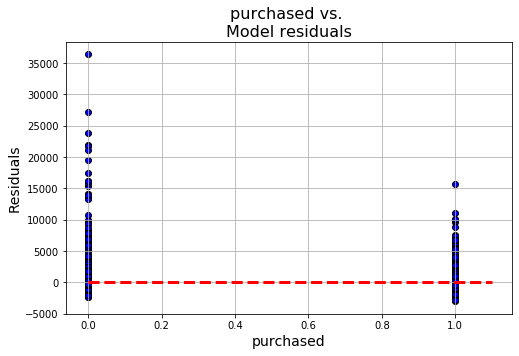

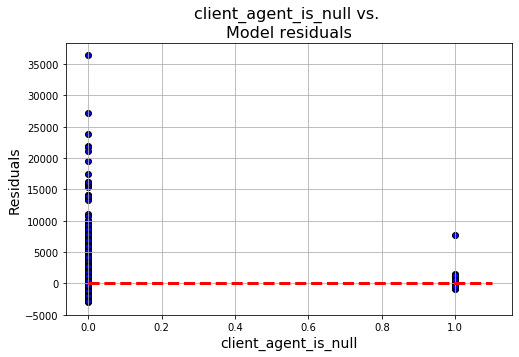

In [11]:
for c in num_cols:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=df[c],y=fitted.resid,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(df[c])
    xmax = max(df[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

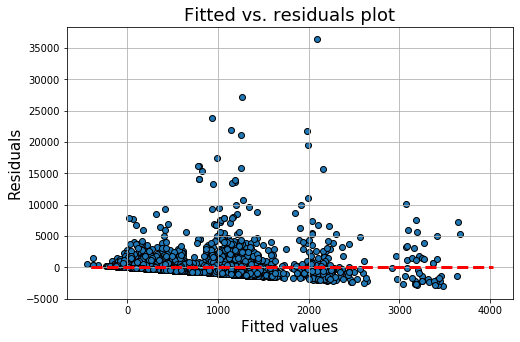

In [12]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

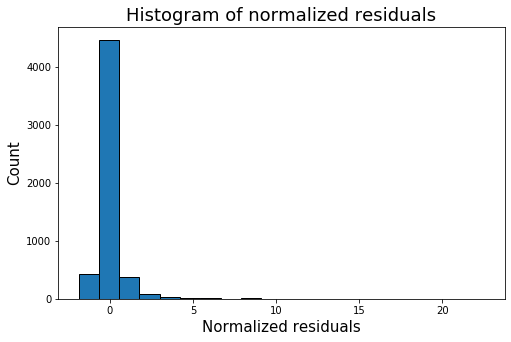

In [13]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

<Figure size 576x360 with 0 Axes>

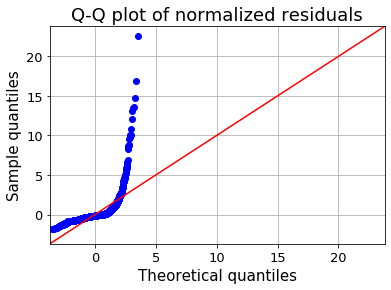

In [14]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

In [15]:
_,p=shapiro(fitted.resid)
if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


/Users/susmitvengurlekar/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


/Users/susmitvengurlekar/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


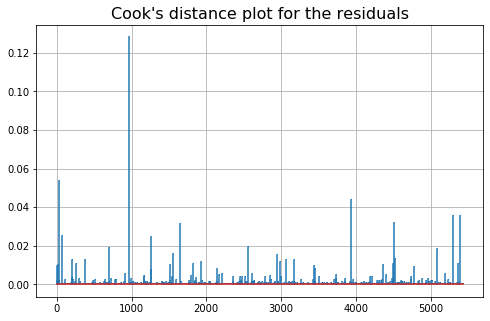

In [16]:
inf=influence(fitted)
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

In [17]:
for i in range(len(num_cols)):
    v=vif(np.matrix(df[num_cols]),i)
    print("Variance inflation factor for {}: {}".format(num_cols[i],round(v,2)))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''